# Explain the Best Model
* To succecfully run this notebook you need a python3.7 kernel with requirements in ./sagemaker-custom-image/requirements.txt

## This notebook will help you to do:
* Import scored data
* Use Shapley Value to explain the model

# 1. Parameters

In [1]:
#Name
ModelName = 'titanic_segmentation_model'

#Setting the VarId and VarDate parameters
VarId = 'PassengerId'
VarDate = 'ReferenceDate'

#process outputs such as MOJO model, images and performance of tested models
OutputPath = './output_model/'

#If you have a huge dataset, I should consider use a small sample for first execution
PctSampleSize = 1


#Version
ModelVersion = 'v1'

#Model ID
ModelId = ModelName+'_'+ModelVersion

#It is necessary to define the types of variables (cageroric and numeric) to ensure that the type of data used in the modeling will be the most suitable.
#For example, categorical variables need to be defined as a string because this prevents it from being treated as a numeric variable in H20 modeling
#Another example is that the string variables will have a missing treatment by placing the missing category for all values found as 'null'
CAT = ['Pclass'
,'Embarked'
,'cabine_prefix'
,'NameTitle'
,'Sex']

#float
NUM = ['Fare'
,'SibSp'
,'Parch'
,'Age_Mean']
selected_features = CAT + NUM

# 2. Import Libraries

In [2]:
# !pip -q install -r requirements.txt

In [3]:
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
import h2o
import seaborn as sns
import altair as alt

# 3. Importing Scored Data for Explain Modeling

In [4]:
datascored_df_full = pd.read_csv('./titanic/df_cluster.csv')

In [5]:
#Work with a sample data if the PctSampleSize is less than 1
if PctSampleSize == 1:
    datascored_df = datascored_df_full.copy()
else:
    datascored_df = datascored_df_full.sample(frac=PctSampleSize, replace=False, random_state=1)
del datascored_df_full

In [6]:
#List all dummies and normalized variables
normalized_and_dummy = []
for i in datascored_df.columns:
    if (i.startswith('dummy_')) or (i.startswith('normalized_')):
        normalized_and_dummy.append(i)
# normalized_and_dummy

In [7]:
#Numeric features must be float type
for col_name in (NUM + normalized_and_dummy):
    datascored_df[col_name] = datascored_df[col_name].astype(float)

#Categorical features must be string type and null values will be filled with "missing"
for col_name in CAT:
    datascored_df[col_name] = datascored_df[col_name].astype(str)

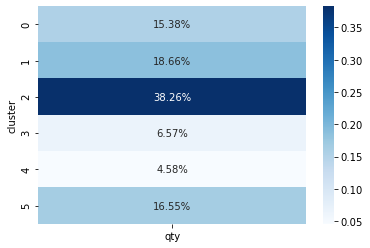

In [27]:
df_cluster_plot = datascored_df.reset_index().groupby(['cluster']).count()[['index']].rename(columns={'index': 'qty'})
# sns.heatmap(df_cluster_plot, annot=True, center=True,cmap='Blues', fmt='g')
# plt.show()
sns.heatmap(df_cluster_plot/np.sum(df_cluster_plot), annot=True,
            fmt='.2%', cmap='Blues')
plt.show()

# 4. Calculate Shapley Values using SHAP KernelExplainer for H20 models

#### The SHAP library calculates the Shaley Value of each variable used in the model and shows the individual impact of each variable on the predicted value for each record. To better understand how the SHAP library works, see the link https://github.com/slundberg/shap

## 4.1 For calculating the shapley value, we need to create a multiclass classification model using the clusters as the target featrure

In [9]:
# Number of threads, nthreads = -1, means use all cores on your machine
# max_mem_size is the maximum memory (in GB) to allocate to H2O
h2o.init(nthreads = -1, max_mem_size = '4G')
# h2o.init(nthreads = -1)

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


--------------------------  -----------------------------
H2O_cluster_uptime:         1 hour 54 mins
H2O_cluster_timezone:       America/Sao_Paulo
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.36.1.2
H2O_cluster_version_age:    5 months and 27 days !!!
H2O_cluster_name:           H2O_from_python_maxde_5kcaqm
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    2.935 Gb
H2O_cluster_total_cores:    12
H2O_cluster_allowed_cores:  12
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://localhost:54321
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
Python_version:             3.7.7 final
--------------------------  -----------------------------

In [10]:
#Setting the model target variable name
VarTarget = 'cluster'

#Import TRAINING base to the H20 context
data_hdf = h2o.H2OFrame(datascored_df.loc[:, (selected_features+[VarTarget])])

# Conversion of Target variables and categorical features to factor (enum)
#no H2O it is necessary that the categorical variables are transformed into a factor
data_hdf[VarTarget] = data_hdf[VarTarget].asfactor()
for col_name in CAT:
    data_hdf[col_name] = data_hdf[col_name].asfactor()
for col_name in NUM:
    data_hdf[col_name] = data_hdf[col_name].asnumeric()
    
# Partition data into 90%, 10% chunks
# Setting a seed will guarantee reproducibility
train_hdf, valid_hdf = data_hdf.split_frame(ratios=[0.90], destination_frames=['train_hdf', 'valid_hdf'], seed=1)
        
#Notice that `split_frame()` uses approximate splitting not exact splitting (for efficiency), so these are not exactly 90%, 10% of the total rows.
print('Training: ' + str(train_hdf.nrow))
print('Validation: ' + str(valid_hdf.nrow))

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Training: 770
Validation: 82


In [11]:
##H2O Parameters:

vModel='AUTOML'

#Set the maximum time in seconds for the H20 AutoML
max_runtime_secs=60*2

#Define metrics to select the best model in AutoML
sort_metric = 'rmse'

#Execution time of the model
start = dt.datetime.now()

from h2o.automl import H2OAutoML
AUTOML = H2OAutoML(seed=1,
#                    exclude_algos=["StackedEnsemble"],
#                    distribution="multinomial",
#                    auc_type="MACRO_OVR",
                   max_runtime_secs = max_runtime_secs,
                   stopping_metric = sort_metric,
                   sort_metric = sort_metric)
AUTOML.train(x=selected_features, y=VarTarget, training_frame = train_hdf, validation_frame = valid_hdf, leaderboard_frame=valid_hdf)

#Execution time of the model
stop = dt.datetime.now()
execution_time = stop-start
print("\n"+ "Execution time: " + str(execution_time) + "\n")

AutoML progress: |█
18:03:40.766: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.
18:03:40.767: AutoML: XGBoost is not available; skipping it.
18:03:42.128: GLM_1_AutoML_3_20221122_180340 [GLM def_1] failed: java.lang.ArrayIndexOutOfBoundsException

██████████████████████████████████████████████████████████████| (done) 100%

Execution time: 0:02:56.139140



In [12]:
#View the AutoML Leaderboard
lb = AUTOML.leaderboard
print(lb.head(rows=lb.nrows))

model_id rmse mean_per_class_error logloss mse 
 
 
 GBM_grid_1_AutoML_3_20221122_180340_model_7 0.288181 0.154679 0.325604 0.0830485 
 GBM_grid_1_AutoML_3_20221122_180340_model_13 0.290376 0.201901 0.409102 0.0843182 
 GBM_grid_1_AutoML_3_20221122_180340_model_5 0.294207 0.224123 0.452919 0.086558 
 GBM_grid_1_AutoML_3_20221122_180340_model_23 0.294826 0.19079 0.408255 0.0869226 
 GBM_3_AutoML_3_20221122_180340 0.297239 0.157457 0.43022 0.0883508 
 GBM_grid_1_AutoML_3_20221122_180340_model_12 0.297597 0.19079 0.449382 0.0885642 
 GBM_grid_1_AutoML_3_20221122_180340_model_8 0.299797 0.201901 0.457032 0.0898785 
 GBM_grid_1_AutoML_3_20221122_180340_model_2 0.29986 0.21579 0.405611 0.0899163 
 GBM_grid_1_AutoML_3_20221122_180340_model_18 0.3007 0.168568 0.365116 0.0904206 
 GBM_grid_1_AutoML_3_20221122_180340_model_1 0.300717 0.21579 0.363108 0.0904306 
 GBM_4_AutoML_3_20221122_180340 0.30089 0.182457 0.424742 0.0905345 
 GBM_grid_1_AutoML_3_20221122_180340_model_10 0.30221 0.182457 0.380911 0.0913312 
 GBM_grid_1_AutoML_3_20221122_180340_model_17 0.302619 0.201901 0.407509 0.0915781 
 GBM_1_AutoML_3_20221122_180340 0.307693 0.238012 0.361991 0.0946748 
 GBM_grid_1_AutoML_3_20221122_180340_model_9 0.30774 0.196345 0.409993 0.0947037 
 GBM_2_AutoML_3_20221122_180340 0.30854 0.238012 0.448001 0.0951967 
 GBM_5_AutoML_3_20221122_180340 0.309067 0.21579 0.460806 0.0955222 
 GBM_grid_1_AutoML_3_20221122_180340_model_20 0.30965 0.182457 0.393378 0.095883 
 GBM_grid_1_AutoML_3_20221122_180340_model_15 0.311622 0.201901 0.368383 0.0971082 
 DRF_1_AutoML_3_20221122_180340 0.312735 0.21579 1.4509 0.0978034 
 GBM_grid_1_AutoML_3_20221122_180340_model_4 0.317219 0.21579 0.397196 0.100628 
 StackedEnsemble_AllModels_1_AutoML_3_20221122_180340 0.31842 0.196345 0.45207 0.101391 
 GBM_grid_1_AutoML_3_20221122_180340_model_11 0.321206 0.238012 0.395389 0.103173 
 StackedEnsemble_BestOfFamily_1_AutoML_3_20221122_180340 0.321316 0.157457 0.47102 0.103244 
 GBM_grid_1_AutoML_3_20221122_180340_model_22 0.321412 0.229679 0.383661 0.103306 
 GBM_grid_1_AutoML_3_20221122_180340_model_3 0.322084 0.229679 0.40135 0.103738 
 GBM_grid_1_AutoML_3_20221122_180340_model_16 0.325416 0.326901 0.36627 0.105896 
 GBM_grid_1_AutoML_3_20221122_180340_model_19 0.326873 0.271345 0.373676 0.106846 
 StackedEnsemble_AllModels_2_AutoML_3_20221122_180340 0.330056 0.21579 0.412782 0.108937 
 GBM_grid_1_AutoML_3_20221122_180340_model_21 0.332692 0.249123 0.53229 0.110684 
 StackedEnsemble_BestOfFamily_2_AutoML_3_20221122_180340 0.337445 0.24079 0.50254 0.113869 
 GBM_grid_1_AutoML_3_20221122_180340_model_6 0.339721 0.326901 0.403046 0.11541 
 GBM_grid_1_AutoML_3_20221122_180340_model_14 0.342217 0.31408 0.389882 0.117113 
 DeepLearning_grid_1_AutoML_3_20221122_180340_model_1 0.343889 0.243568 0.691981 0.11826 
 DeepLearning_grid_1_AutoML_3_20221122_180340_model_3 0.344557 0.326901 0.452507 0.11872 
 StackedEnsemble_BestOfFamily_3_AutoML_3_20221122_180340 0.357936 0.29079 0.42518 0.128118 
 DeepLearning_grid_1_AutoML_3_20221122_180340_model_2 0.359922 0.360234 0.472048 0.129544 
 DeepLearning_grid_1_AutoML_3_20221122_180340_model_4 0.369424 0.388012 0.479447 0.136474 
 DeepLearning_grid_1_AutoML_3_20221122_180340_model_5 0.369918 0.313012 0.485915 0.136839 
 DeepLearning_1_AutoML_3_20221122_180340 0.378054 0.360234 0.48541 0.142925 
 DeepLearning_grid_1_AutoML_3_20221122_180340_model_6 0.441232 0.421345 0.641948 0.194686 
 XRT_1_AutoML_3_20221122_180340 0.4471 0.329679 1.09583 0.199899 
 StackedEnsemble_AllModels_3_AutoML_3_20221122_180340 0.76282 0.833333 1.54644 0.581895

In [13]:
#Choose the desired AutoML model
best_automl_position=0
if len(AUTOML.leaderboard) > 0:
    best_AutoML = h2o.get_model(AUTOML.leaderboard[best_automl_position, 0])
    print(best_AutoML)

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_grid_1_AutoML_3_20221122_180340_model_7


Model Summary: 


number_of_trees  number_of_internal_trees  model_size_in_bytes  \
0               78.0                     468.0              70406.0   

   min_depth  max_depth  mean_depth  min_leaves  max_leaves  mean_leaves  
0        3.0        3.0         3.0         4.0         8.0     7.326923



ModelMetricsMultinomial: gbm
** Reported on train data. **

MSE: 0.015757768730714224
RMSE: 0.1255299515283672
LogLoss: 0.07188608901315302
Mean Per-Class Error: 0.030267662620603795
AUC: NaN
AUCPR: NaN
Multinomial auc values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).
Multinomial auc_pr values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


0      1      2     3     4      5     Error     Rate
0  118.0    0.0    0.0   1.0   0.0    0.0  0.008403  1 / 119
1    0.0  139.0    0.0   0.0   0.0    0.0  0.000000  0 / 139
2    0.0    0.0  297.0   0.0   0.0    0.0  0.000000  0 / 297
3    2.0    4.0    0.0  45.0   0.0    0.0  0.117647   6 / 51
4    1.0    1.0    0.0   0.0  34.0    0.0  0.055556   2 / 36
5    0.0    0.0    0.0   0.0   0.0  128.0  0.000000  0 / 128
6  121.0  144.0  297.0  46.0  34.0  128.0  0.011688  9 / 770


Top-6 Hit Ratios: 


k  hit_ratio
0  1   0.988312
1  2   1.000000
2  3   1.000000
3  4   1.000000
4  5   1.000000
5  6   1.000000


ModelMetricsMultinomial: gbm
** Reported on validation data. **

MSE: 0.08304854808041895
RMSE: 0.28818144992420824
LogLoss: 0.3256039320681565
Mean Per-Class Error: 0.15467875036840553
AUC: NaN
AUCPR: NaN
Multinomial auc values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).
Multinomial auc_pr values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


0     1     2    3    4     5     Error    Rate
0  11.0   0.0   0.0  1.0  0.0   0.0  0.083333  1 / 12
1   0.0  20.0   0.0  0.0  0.0   0.0  0.000000  0 / 20
2   0.0   0.0  28.0  0.0  1.0   0.0  0.034483  1 / 29
3   0.0   1.0   0.0  3.0  0.0   1.0  0.400000   2 / 5
4   1.0   0.0   0.0  0.0  2.0   0.0  0.333333   1 / 3
5   0.0   0.0   0.0  1.0  0.0  12.0  0.076923  1 / 13
6  12.0  21.0  28.0  5.0  3.0  13.0  0.073171  6 / 82


Top-6 Hit Ratios: 


k  hit_ratio
0  1   0.926829
1  2   0.975610
2  3   1.000000
3  4   1.000000
4  5   1.000000
5  6   1.000000


ModelMetricsMultinomial: gbm
** Reported on cross-validation data. **

MSE: 0.06036915361926209
RMSE: 0.24570135046283748
LogLoss: 0.2095161172693119
Mean Per-Class Error: 0.15839549998656535
AUC: NaN
AUCPR: NaN
Multinomial auc values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).
Multinomial auc_pr values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


0      1      2     3     4      5     Error      Rate
0  106.0    0.0    1.0   6.0   6.0    0.0  0.109244  13 / 119
1    0.0  136.0    0.0   2.0   1.0    0.0  0.021583   3 / 139
2    0.0    0.0  297.0   0.0   0.0    0.0  0.000000   0 / 297
3   11.0    9.0    0.0  27.0   0.0    4.0  0.470588   24 / 51
4    9.0    3.0    0.0   0.0  24.0    0.0  0.333333   12 / 36
5    0.0    0.0    0.0   2.0   0.0  126.0  0.015625   2 / 128
6  126.0  148.0  298.0  37.0  31.0  130.0  0.070130  54 / 770


Top-6 Hit Ratios: 


k  hit_ratio
0  1   0.929870
1  2   0.994805
2  3   0.996104
3  4   0.998701
4  5   1.000000
5  6   1.000000


Cross-Validation Metrics Summary: 


mean        sd  cv_1_valid  cv_2_valid  \
0                  accuracy   0.927273  0.037696    0.883117    0.889610   
1                       auc        NaN  0.000000         NaN         NaN   
2                       err   0.072727  0.037696    0.116883    0.110390   
3                 err_count  11.200000  5.805170   18.000000   17.000000   
4                   logloss   0.209738  0.062086    0.269297    0.284957   
5       max_per_class_error   0.465675  0.169984    0.687500    0.571429   
6   mean_per_class_accuracy   0.856520  0.061932    0.798285    0.781429   
7      mean_per_class_error   0.143480  0.061932    0.201715    0.218571   
8                       mse   0.060715  0.020857    0.087396    0.078708   
9                    pr_auc        NaN  0.000000         NaN         NaN   
10                       r2   0.976156  0.006207    0.967641    0.971664   
11                     rmse   0.243573  0.041641    0.295627    0.280550   

    cv_3_valid  cv_4_valid  cv_5_valid  
0     0.948052    0.954545    0.961039  
1          NaN         NaN         NaN  
2     0.051948    0.045455    0.038961  
3     8.000000    7.000000    6.000000  
4     0.168122    0.171575    0.154738  
5     0.375000    0.250000    0.444444  
6     0.907317    0.910556    0.885017  
7     0.092683    0.089444    0.114983  
8     0.046675    0.049761    0.041036  
9          NaN         NaN         NaN  
10    0.981910    0.978776    0.980788  
11    0.216045    0.223071    0.202574


Scoring History: 


timestamp    duration  number_of_trees  training_rmse  \
0     2022-11-22 18:05:07   4.293 sec              0.0       0.833333   
1     2022-11-22 18:05:07   4.303 sec              5.0       0.652610   
2     2022-11-22 18:05:07   4.317 sec             10.0       0.530874   
3     2022-11-22 18:05:07   4.329 sec             15.0       0.429942   
4     2022-11-22 18:05:07   4.341 sec             20.0       0.362635   
5     2022-11-22 18:05:07   4.352 sec             25.0       0.307705   
6     2022-11-22 18:05:07   4.365 sec             30.0       0.262883   
7     2022-11-22 18:05:07   4.378 sec             35.0       0.233631   
8     2022-11-22 18:05:07   4.390 sec             40.0       0.214782   
9     2022-11-22 18:05:07   4.402 sec             45.0       0.194507   
10    2022-11-22 18:05:07   4.415 sec             50.0       0.179114   
11    2022-11-22 18:05:07   4.426 sec             55.0       0.170067   
12    2022-11-22 18:05:07   4.439 sec             60.0       0.155824   
13    2022-11-22 18:05:08   4.481 sec             65.0       0.146661   
14    2022-11-22 18:05:08   4.491 sec             70.0       0.136920   
15    2022-11-22 18:05:08   4.501 sec             75.0       0.130318   
16    2022-11-22 18:05:08   4.507 sec             78.0       0.125530   

    training_logloss  training_classification_error  training_auc  \
0           1.791759                       0.775325           NaN   
1           1.082294                       0.141558           NaN   
2           0.774051                       0.137662           NaN   
3           0.555657                       0.092208           NaN   
4           0.422139                       0.074026           NaN   
5           0.325551                       0.058442           NaN   
6           0.253264                       0.049351           NaN   
7           0.207814                       0.040260           NaN   
8           0.179865                       0.032468           NaN   
9           0.151914                       0.025974           NaN   
10          0.131133                       0.020779           NaN   
11          0.117364                       0.020779           NaN   
12          0.101629                       0.019481           NaN   
13          0.091268                       0.018182           NaN   
14          0.082425                       0.012987           NaN   
15          0.076120                       0.014286           NaN   
16          0.071886                       0.011688           NaN   

    training_pr_auc  validation_rmse  validation_logloss  \
0               NaN         0.833333            1.791759   
1               NaN         0.666158            1.125374   
2               NaN         0.562065            0.853042   
3               NaN         0.478806            0.662072   
4               NaN         0.433089            0.558516   
5               NaN         0.396208            0.482954   
6               NaN         0.363632            0.419553   
7               NaN         0.343650            0.384255   
8               NaN         0.331798            0.363247   
9               NaN         0.317352            0.343923   
10              NaN         0.307164            0.330868   
11              NaN         0.301008            0.320267   
12              NaN         0.294762            0.315965   
13              NaN         0.292635            0.316876   
14              NaN         0.288808            0.317307   
15              NaN         0.287182            0.321663   
16              NaN         0.288181            0.325604   

    validation_classification_error  validation_auc  validation_pr_auc  
0                          0.804878             NaN                NaN  
1                          0.170732             NaN                NaN  
2                          0.170732             NaN                NaN  
3                          0.134146             NaN                NaN  
4           


Variable Importances: 


variable  relative_importance  scaled_importance  percentage
0         Pclass           428.505096           1.000000    0.217549
1           Fare           411.733063           0.960859    0.209034
2  cabine_prefix           372.086243           0.868336    0.188905
3      NameTitle           312.942780           0.730313    0.158879
4            Sex           227.702530           0.531388    0.115603
5       Age_Mean            83.771332           0.195497    0.042530
6       Embarked            62.597717           0.146084    0.031780
7          SibSp            50.918346           0.118828    0.025851
8          Parch            19.441195           0.045370    0.009870

In [14]:
h2o_predict = best_AutoML.predict(data_hdf)
df_predict = h2o_predict.cbind(data_hdf).as_data_frame()
df_predict

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


predict        p0        p1        p2        p3        p4        p5  \
0          2  0.000193  0.001158  0.997467  0.000127  0.000459  0.000597   
1          3  0.110357  0.000475  0.000131  0.884698  0.002169  0.002169   
2          0  0.946119  0.002583  0.000275  0.045406  0.001105  0.004513   
3          2  0.000155  0.001406  0.997405  0.000097  0.000484  0.000453   
4          2  0.000125  0.000291  0.998644  0.000079  0.000351  0.000510   
..       ...       ...       ...       ...       ...       ...       ...   
847        1  0.000131  0.997542  0.000249  0.000518  0.001486  0.000074   
848        0  0.915484  0.008218  0.000273  0.065903  0.000893  0.009230   
849        5  0.001720  0.006243  0.005923  0.009581  0.000651  0.975882   
850        0  0.859844  0.006095  0.003198  0.007088  0.123058  0.000717   
851        2  0.000117  0.000365  0.998659  0.000074  0.000305  0.000480   

     Pclass Embarked cabine_prefix NameTitle     Sex     Fare  SibSp  Parch  \
0         3        S       missing        Mr    male   7.2500      1      0   
1         1        C             C       Mrs  female  71.2833      1      0   
2         1        S             C       Mrs  female  53.1000      1      0   
3         3        S       missing        Mr    male   8.0500      0      0   
4         3        Q       missing        Mr    male   8.4583      0      0   
..      ...      ...           ...       ...     ...      ...    ...    ...   
847       2        S       missing       LOW    male  13.0000      0      0   
848       1        S             B      Miss  female  30.0000      0      0   
849       3        S       missing      Miss  female  23.4500      1      2   
850       1        C             C        Mr    male  30.0000      0      0   
851       3        Q       missing        Mr    male   7.7500      0      0   

      Age_Mean  cluster  
0    22.000000        2  
1    38.000000        3  
2    35.000000        0  
3    35.000000        2  
4    29.699118        2  
..         ...      ...  
847  27.000000        1  
848  19.000000        0  
849  29.699118        5  
850  26.000000        0  
851  32.000000        2  

[852 rows x 17 columns]

In [15]:
#Funcao para calcular o valor de shapley
class H2oProbWrapper:
    def __init__(self, h2o_model, feature_names, NUM, CAT):
        self.h2o_model = h2o_model
        self.feature_names = feature_names
        self.NUM = NUM
        self.CAT = CAT
    def predict_binary_prob(self, X):
        if isinstance(X, pd.Series):
            X = X.values.reshape(1,-1) 
        self.dataframe = pd.DataFrame(X, columns=self.feature_names)

        #Numeric features must be float type
        for col_name in self.NUM:
            self.dataframe[col_name] = self.dataframe[col_name].astype(float)

        #Categorical features must be string type and null values will be filled with "Missing"
        for col_name in self.CAT:        
            self.dataframe = self.dataframe.astype(str)
            self.dataframe = self.dataframe.fillna(value={col_name: 'Missing'})

        self.predictions = h2o.mojo_predict_pandas(self.dataframe.set_index(self.feature_names[0], inplace=False), mojo_zip_path=self.h2o_model, verbose=False)
        return self.predictions.drop(columns='predict').astype('float64').values

In [16]:
#The calculation of the Shapley Value for H20 models takes a while. So it will only be done for 20 records. Increase the sample to deepen your analysis
shap_sample = df_predict.loc[:,(selected_features)].sample(n=30, replace=False, random_state=1)
shap_sample = shap_sample.fillna(0)

In [17]:
path_model_mojo = best_AutoML.download_mojo('%s/models/best/' % OutputPath, get_genmodel_jar=True)
path_model_mojo

'D:\\OneDrive\\FIEP\\FIEP-Machine-Learning-e-Computacao-em-Nuvem\\clusters_segmentation\\output_model\\models\\best\\GBM_grid_1_AutoML_3_20221122_180340_model_7.zip'

In [19]:
h2o_wrapper = H2oProbWrapper(path_model_mojo, selected_features, NUM, CAT)
h2o_explainer = shap.KernelExplainer(h2o_wrapper.predict_binary_prob, shap_sample)
h2o_shap_values = h2o_explainer.shap_values(shap_sample, nsamples="auto")

## 4.1 Main SHAP Graphics

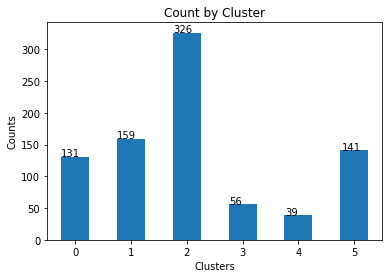

In [20]:
ax = df_predict.reset_index().groupby('cluster').agg('index').count().plot(kind='bar', stacked=False, ylabel='Counts', xlabel='Clusters',
             title='Count by Cluster', rot=0)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

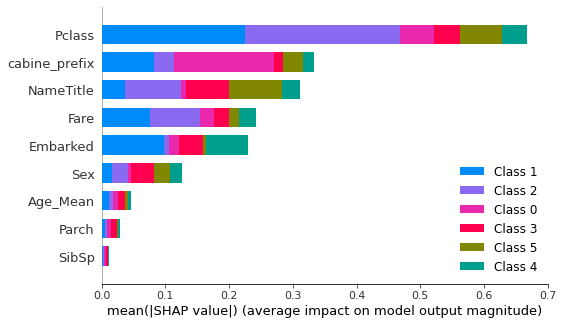

None

In [21]:
fig = shap.summary_plot(h2o_shap_values, shap_sample, plot_type="bar", show=True)
display(fig)

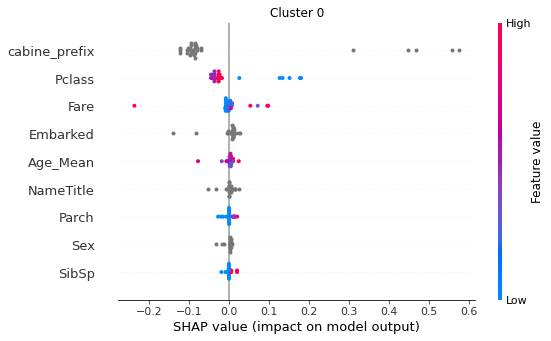

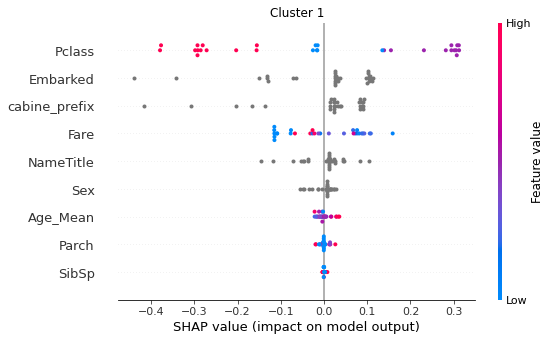

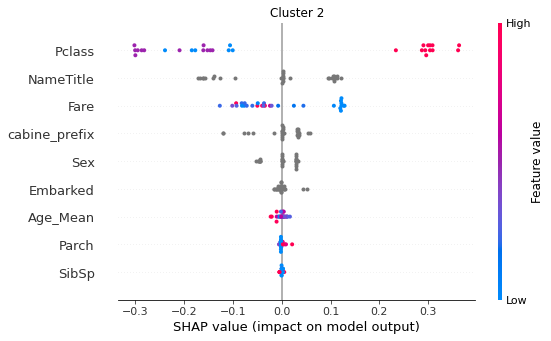

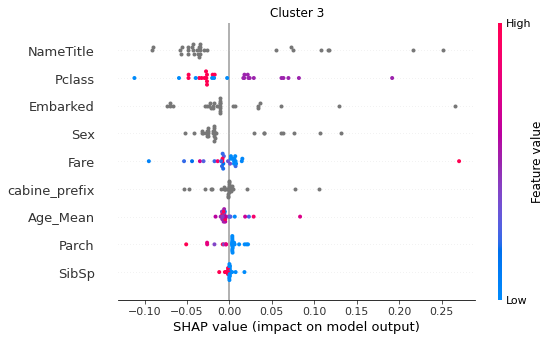

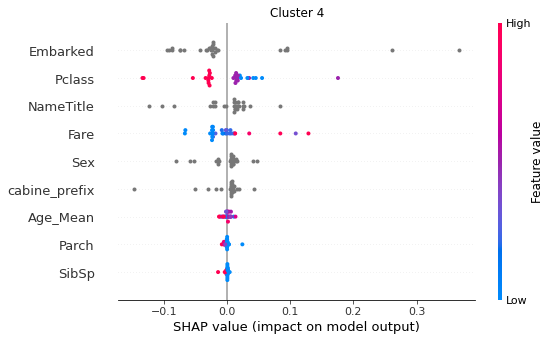

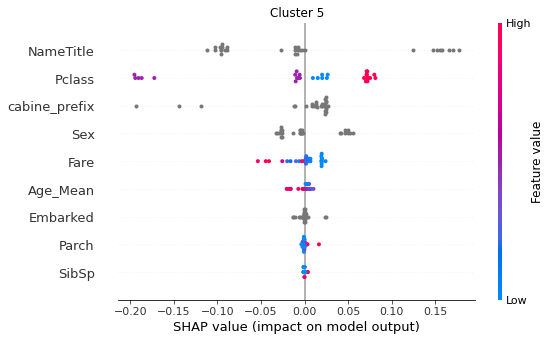

In [22]:
for cnr in range(len(df_predict['cluster'].unique())):
    shap.summary_plot(h2o_shap_values[cnr], shap_sample[selected_features], max_display=30, show=False)
    plt.title(f'Cluster {cnr}')
    plt.show()

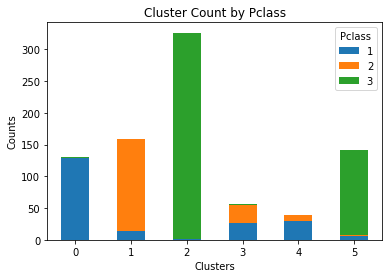

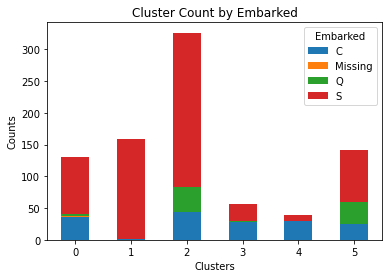

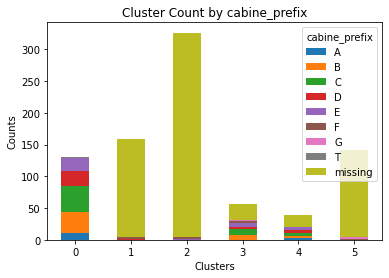

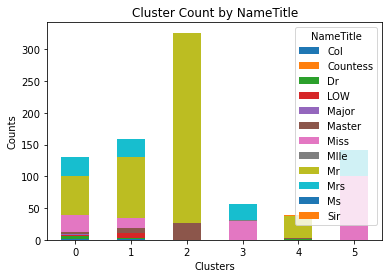

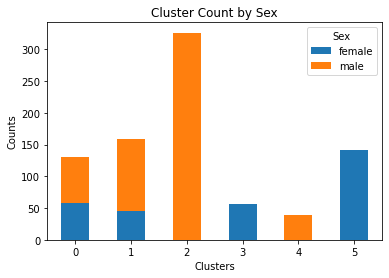

In [23]:
for i in CAT:
    # create a pivot table
    dfp = df_predict[[i,'cluster']].pivot_table(index='cluster', columns=[i], aggfunc=len)

    # plot the dataframe
    dfp.plot(kind='bar', stacked=True, ylabel='Counts', xlabel='Clusters',
             title=f'Cluster Count by {i}', rot=0)

In [24]:
def plot_comparison(data, feature):
    print(feature)
    cluster_qty = len(data['cluster'].unique())

    fig, ax = plt.subplots(cluster_qty, 1, sharex=True, constrained_layout=True, figsize=(15,cluster_qty))
    fig.suptitle(f'Feature {feature}', fontsize=16)

    for j in range(cluster_qty):
        sns.violinplot(x=data.query(f'cluster == {j}')[i].rename(""), ax=ax[j])
        ax[j].set_title('Cluster ' + str(j))
    plt.show()
    plt.close()

Fare


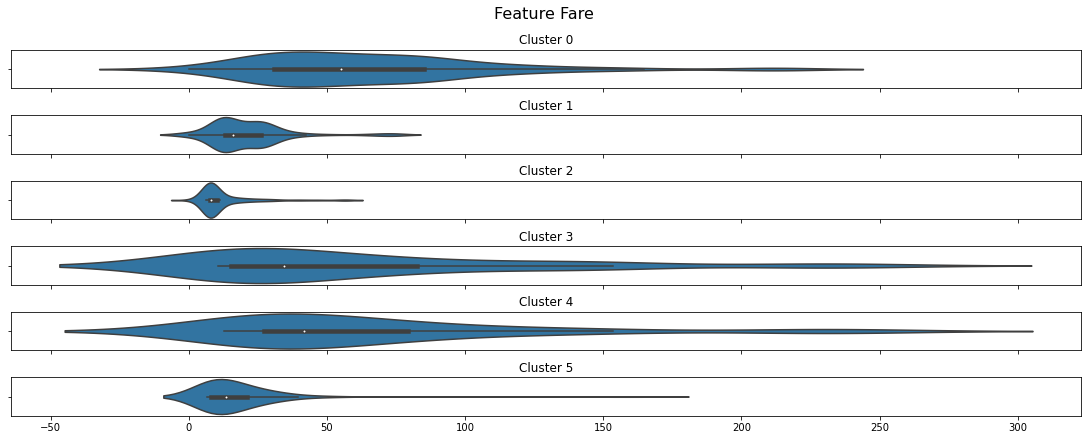

alt.FacetChart(...)

alt.FacetChart(...)

alt.FacetChart(...)

SibSp


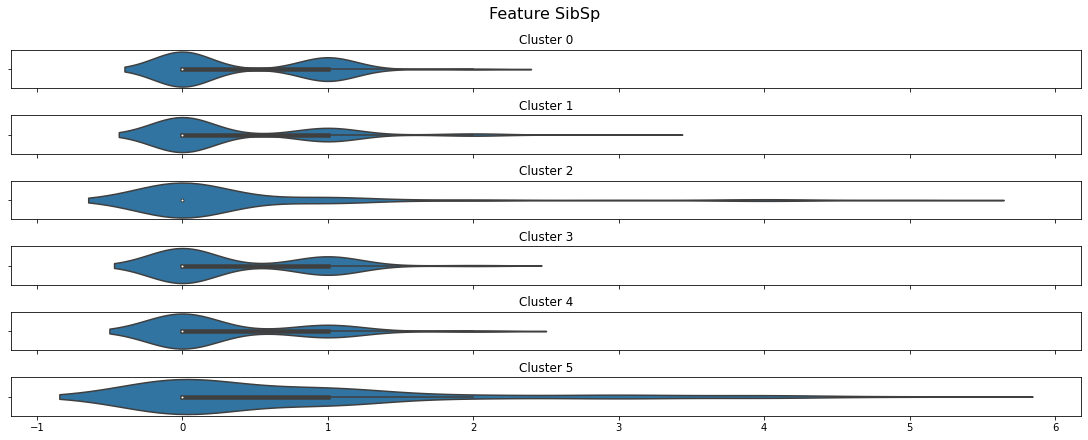

alt.FacetChart(...)

alt.FacetChart(...)

alt.FacetChart(...)

Parch


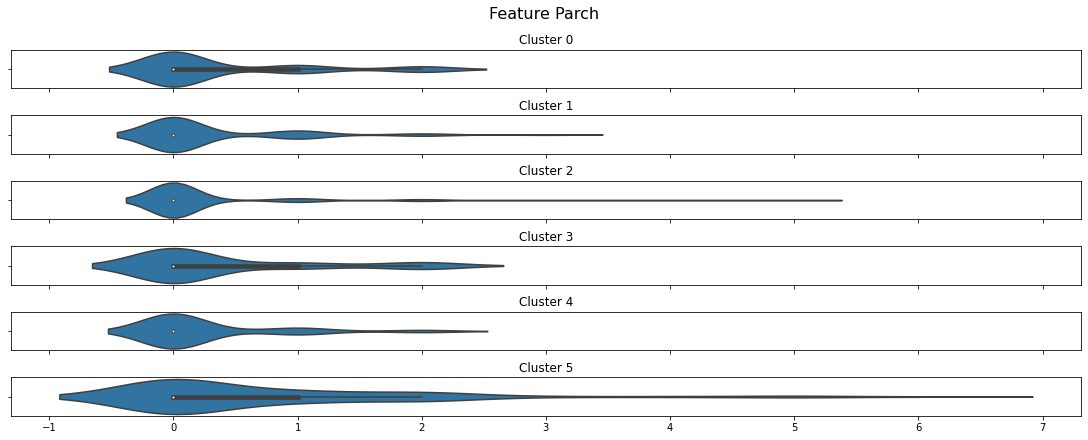

alt.FacetChart(...)

alt.FacetChart(...)

alt.FacetChart(...)

Age_Mean


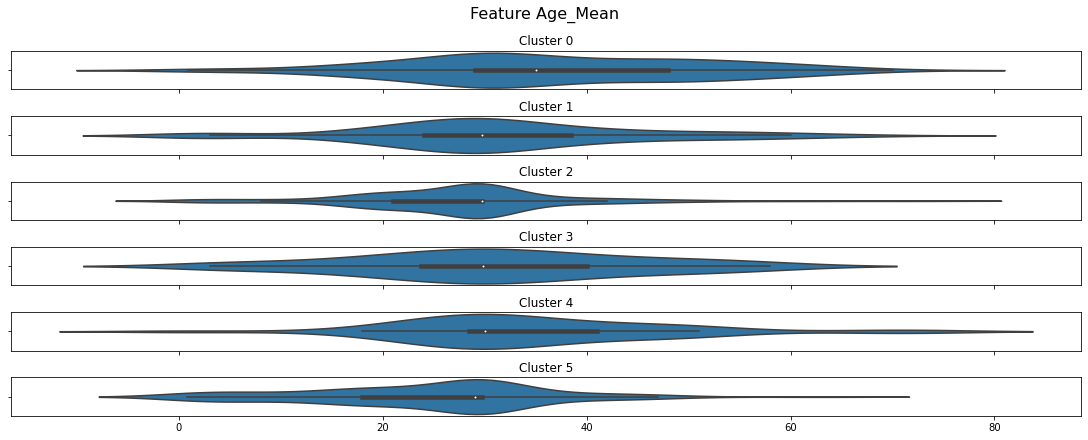

alt.FacetChart(...)

alt.FacetChart(...)

alt.FacetChart(...)

In [26]:
for i in NUM:
    plot_comparison(df_predict[[i]+['cluster']], i)
    
    cluster_qty = len(df_predict['cluster'].unique())
    for j in NUM:
        if i!=j:
            display(alt.Chart(df_predict).mark_point().encode(x=str(j)+':Q', y=str(i)+':Q', color='cluster:N', tooltip=selected_features).interactive().properties(
                    width=180,
                    height=180
                    ).facet(
                    facet='cluster:N',
                    columns=cluster_qty
                    ).resolve_axis(
                    x='independent',
                    y='independent',
                    ))